# Ford GoBike Data Visualization
## by Emily Aquin

## Preliminary Wrangling

> Using the Lyft app, you can rent a bicycle in the Bay Area. Within a service area, you can pick up and drop off a bicycle, based on your current needs. This project analyzes the data collected from users of the GoBike program, for 2017 and 2018. The data can be found at https://www.lyft.com/bikes/bay-wheels/system-data

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
folder_data = 'info'

In [3]:
makedirs(folder_data)
pd.read_csv('https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv').to_csv('{}/2017-forgobike-tripdata.csv'.format(folder_data))
for month in range(1,12):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2018' + month_leading_zero + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # code below opens zip file; BytesIO returns a view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # places extracted zip file into folder_data
    unzipped_file.extractall(folder_data)

In [4]:
# Combine all downloaded CSVs into one 
list_data = []
for file_name in listdir(folder_data):
    list_data.append(pd.read_csv(folder_data+'/'+file_name))
df = pd.concat(list_data, join = 'inner', sort=True)

In [5]:
df.head()

,bike_id,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type
0,1035,598,114.0,37.764478,-122.402570,Rhode Island St at 17th St,2018-03-01 00:09:45.1870,1988.0,Male,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2018-02-28 23:59:47.0970,Subscriber
1,1673,943,324.0,37.788300,-122.408531,Union Square (Powell St at Post St),2018-02-28 23:36:59.9740,1987.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-02-28 23:21:16.4950,Customer
2,3498,18587,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2018-02-28 23:30:42.9250,1986.0,Female,93.0,37.770407,-122.391198,4th St at Mission Bay Blvd S,2018-02-28 18:20:55.1900,Customer
3,3129,18558,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2018-02-28 23:30:12.4500,1981.0,Male,93.0,37.770407,-122.391198,4th St at Mission Bay Blvd S,2018-02-28 18:20:53.6210,Customer
4,1839,885,297.0,37.322980,-121.887931,Locust St at Grant St,2018-02-28 23:29:58.6080,1976.0,Female,308.0,37.336802,-121.894090,San Pedro Square,2018-02-28 23:15:12.8580,Subscriber


### What is the structure of your dataset?


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2252058 entries, 0 to 131168
Data columns (total 15 columns):
bike_id                    int64
duration_sec               int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   object
member_birth_year          float64
member_gender              object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 object
user_type                  object
dtypes: float64(7), int64(2), object(6)
memory usage: 274.9+ MB


In [7]:
df.shape

(2252058, 15)

In [8]:
df.isnull().sum()

bike_id                         0
duration_sec                    0
end_station_id              11579
end_station_latitude            0
end_station_longitude           0
end_station_name            11579
end_time                        0
member_birth_year          172248
member_gender              171818
start_station_id            11579
start_station_latitude          0
start_station_longitude         0
start_station_name          11579
start_time                      0
user_type                       0
dtype: int64

### What is the structure of your dataset?

The dataset includes:
* an ID number for each bicycle
* how long it was rented for, in seconds
* the beginning and end staton ID, latitude, longitude and station name
* the start and end time
* the year the user was born
* the gender of the user
* whether the user has a subscription to the service or not

There are 2252058 rows and 15 columns 

### What is/are the main feature(s) of interest in your dataset?

I'm most interested in figuring out how customers versus subscribers use the service, in terms of length of ride, distance of ride, their average age, and their gender.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that subscribers will ride for a longer time and distance, since they have indicated a strong interest in the service by signing up for it.

## Cleaning the data
### Make a copy before cleaning the data

In [9]:
df_1 = df.copy()

#### Define

Drop end_station_id and end_station_name, since they will not be used.  

#### Code

In [10]:
df_1.drop(columns =['end_station_id', 'end_station_name'], inplace=True)

#### Test

In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2252058 entries, 0 to 131168
Data columns (total 13 columns):
bike_id                    int64
duration_sec               int64
end_station_latitude       float64
end_station_longitude      float64
end_time                   object
member_birth_year          float64
member_gender              object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 object
user_type                  object
dtypes: float64(6), int64(2), object(5)
memory usage: 240.5+ MB


#### Define

Delete the rows without gender or birth year

#### Code

In [12]:
df_1.dropna(subset = ['member_birth_year', 'member_gender'], inplace=True)

#### Test

In [13]:
df_1.isnull().sum()

bike_id                        0
duration_sec                   0
end_station_latitude           0
end_station_longitude          0
end_time                       0
member_birth_year              0
member_gender                  0
start_station_id           11257
start_station_latitude         0
start_station_longitude        0
start_station_name         11257
start_time                     0
user_type                      0
dtype: int64

#### Define

Only use ages that are reasonable. Check for abnormally old or young values and remove them.

#### Code

In [14]:
#Create column for user's age
df_1['member_age'] = 2018-df_1['member_birth_year'].astype('int')

Check for Outliers

In [15]:
df_1['member_age'].max()

137

In [16]:
df_1['member_age'].min()

18

137 years old is unreasonable, 18 years old is an acceptable value

In [17]:
df_age_abnormal = df_1[df_1['member_age'] > 80]
df_age_abnormal

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,member_age
813,983,736,37.776598,-122.395282,2018-02-28 18:20:32.9820,1924.0,Male,16.0,37.794130,-122.394430,Steuart St at Market St,2018-02-28 18:08:16.1930,Subscriber,94
2088,3207,204,37.804562,-122.271738,2018-02-28 13:52:29.0440,1935.0,Male,339.0,37.800002,-122.266438,Jackson St at 11th St,2018-02-28 13:49:04.8710,Subscriber,83
3703,2401,640,37.795392,-122.394203,2018-02-28 08:21:51.5150,1924.0,Male,67.0,37.776639,-122.395526,San Francisco Caltrain Station 2 (Townsend St...,2018-02-28 08:11:11.0000,Subscriber,94
3754,3369,775,37.760299,-122.418892,2018-02-28 08:15:37.0880,1911.0,Other,145.0,37.743684,-122.426806,29th St at Church St,2018-02-28 08:02:41.3960,Subscriber,107
4567,1788,363,37.747300,-122.411403,2018-02-27 20:16:12.4090,1911.0,Other,146.0,37.742314,-122.423180,30th St at San Jose Ave,2018-02-27 20:10:09.2030,Subscriber,107
5200,1782,614,37.776598,-122.395282,2018-02-27 18:17:54.1330,1924.0,Male,23.0,37.791464,-122.391034,The Embarcadero at Steuart St,2018-02-27 18:07:39.3080,Subscriber,94
5784,1848,932,37.764478,-122.402570,2018-02-27 17:14:50.4250,1928.0,Other,22.0,37.789756,-122.394643,Howard St at Beale St,2018-02-27 16:59:17.9550,Subscriber,90
6389,3161,425,37.792251,-122.397086,2018-02-27 14:50:41.7400,1928.0,Other,5.0,37.783899,-122.408445,Powell St BART Station (Market St at 5th St),2018-02-27 14:43:35.9570,Subscriber,90
6949,3671,369,37.804770,-122.403234,2018-02-27 11:02:23.1630,1900.0,Other,8.0,37.799953,-122.398525,The Embarcadero at Vallejo St,2018-02-27 10:56:14.1190,Customer,118
7189,1642,1826,37.800754,-122.274894,2018-02-27 09:58:31.8540,1900.0,Other,166.0,37.851376,-122.252523,College Ave at Alcatraz Ave,2018-02-27 09:28:05.5930,Customer,118


In [18]:
#drop those rows
df_1 = df_1.drop(df_age_abnormal.index, axis=0)

#### Test

In [19]:
#confirm the changes
df_1.shape

(2054059, 14)

Resource: https://stackoverflow.com/questions/14661701/how-to-drop-a-list-of-rows-from-pandas-dataframe

#### Define

Change data types, including times to datetimes, and user_type and member_gender to categories

#### Code

In [20]:
#change start_time and end_time to datetime
df_1['start_time'] = pd.to_datetime(df_1['start_time'])
df_1['end_time'] = pd.to_datetime(df_1['end_time'])
df_1 = df_1.sort_values(by='start_time')

In [21]:
#change duration_sec to minutes, as the visualization will be easier to interpret
df_1['duration_min'] = df_1['duration_sec'] / 60

In [22]:
#change duration_sec to minutes, as the visualization will be easier to interpret
df_1['duration_hours'] = df_1['duration_min'] / 60

In [23]:
#change user_type and gender to category type
df_1.user_type = df_1.user_type.astype('category')
df_1.member_gender = df_1.member_gender.astype('category')

#### Test

In [24]:
#confirm changes to datatypes
df_1.head()

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,member_age,duration_min,duration_hours
519697,240,424,37.782411,-122.392706,2017-06-28 09:54:41.187,1985.0,Female,21.0,37.789625,-122.400811,Montgomery St BART Station (Market St at 2nd St),2017-06-28 09:47:36.347,Subscriber,33,7.066667,0.117778
519698,669,366,37.774814,-122.418954,2017-06-28 09:53:47.715,1981.0,Male,58.0,37.776619,-122.417385,Market St at 10th St,2017-06-28 09:47:41.664,Subscriber,37,6.100000,0.101667
519699,117,188,37.782411,-122.392706,2017-06-28 09:52:55.338,1984.0,Male,25.0,37.787522,-122.397405,Howard St at 2nd St,2017-06-28 09:49:46.377,Subscriber,34,3.133333,0.052222
519692,77,1201,37.798572,-122.400869,2017-06-28 10:11:00.359,1985.0,Male,81.0,37.775880,-122.393170,Berry St at 4th St,2017-06-28 09:50:59.175,Subscriber,33,20.016667,0.333611
519696,316,431,37.780146,-122.403071,2017-06-28 10:03:51.090,1973.0,Male,66.0,37.778742,-122.392741,3rd St at Townsend St,2017-06-28 09:56:39.631,Subscriber,45,7.183333,0.119722


#### Define
Extract months and days of the week from start_time

#### Code

In [25]:
# extract start time month name
df_1['start_time_month_name']=df_1['start_time'].dt.strftime('%B')

In [26]:
# extract start time weekdays
df_1['start_time_weekday']=df_1['start_time'].dt.strftime('%a')

In [27]:
#change both to category type
df_1.start_time_month_name = df_1.start_time_month_name.astype('category')
df_1.start_time_weekday = df_1.start_time_weekday.astype('category')

#### Test

In [28]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054059 entries, 519697 to 2
Data columns (total 18 columns):
bike_id                    int64
duration_sec               int64
end_station_latitude       float64
end_station_longitude      float64
end_time                   datetime64[ns]
member_birth_year          float64
member_gender              category
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  category
member_age                 int64
duration_min               float64
duration_hours             float64
start_time_month_name      category
start_time_weekday         category
dtypes: category(4), datetime64[ns](2), float64(8), int64(3), object(1)
memory usage: 242.9+ MB


#### Define

Create a column for distance in kilometers, based on the longitude and latitude start and end points.

#### Code

In [29]:
import math
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
* math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d



In [30]:
df_1['distance_km'] = df_1.apply(lambda i: distance([i['start_station_longitude'],i['start_station_latitude']],
                            [i['end_station_longitude'],i['end_station_latitude']]), axis=1)

#### Test

In [31]:
df_1.head()

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,member_age,duration_min,duration_hours,start_time_month_name,start_time_weekday,distance_km
519697,240,424,37.782411,-122.392706,2017-06-28 09:54:41.187,1985.0,Female,21.0,37.789625,-122.400811,Montgomery St BART Station (Market St at 2nd St),2017-06-28 09:47:36.347,Subscriber,33,7.066667,0.117778,June,Wed,0.998476
519698,669,366,37.774814,-122.418954,2017-06-28 09:53:47.715,1981.0,Male,58.0,37.776619,-122.417385,Market St at 10th St,2017-06-28 09:47:41.664,Subscriber,37,6.100000,0.101667,June,Wed,0.204976
519699,117,188,37.782411,-122.392706,2017-06-28 09:52:55.338,1984.0,Male,25.0,37.787522,-122.397405,Howard St at 2nd St,2017-06-28 09:49:46.377,Subscriber,34,3.133333,0.052222,June,Wed,0.604730
519692,77,1201,37.798572,-122.400869,2017-06-28 10:11:00.359,1985.0,Male,81.0,37.775880,-122.393170,Berry St at 4th St,2017-06-28 09:50:59.175,Subscriber,33,20.016667,0.333611,June,Wed,1.600173
519696,316,431,37.780146,-122.403071,2017-06-28 10:03:51.090,1973.0,Male,66.0,37.778742,-122.392741,3rd St at Townsend St,2017-06-28 09:56:39.631,Subscriber,45,7.183333,0.119722,June,Wed,1.151688


Resource: https://gist.github.com/rochacbruno/2883505

#### Define
Create a map of starting points to visualize the area where the rides take place.

In [32]:
street_map = gpd.read_file('data/jw123vr9109.shp')

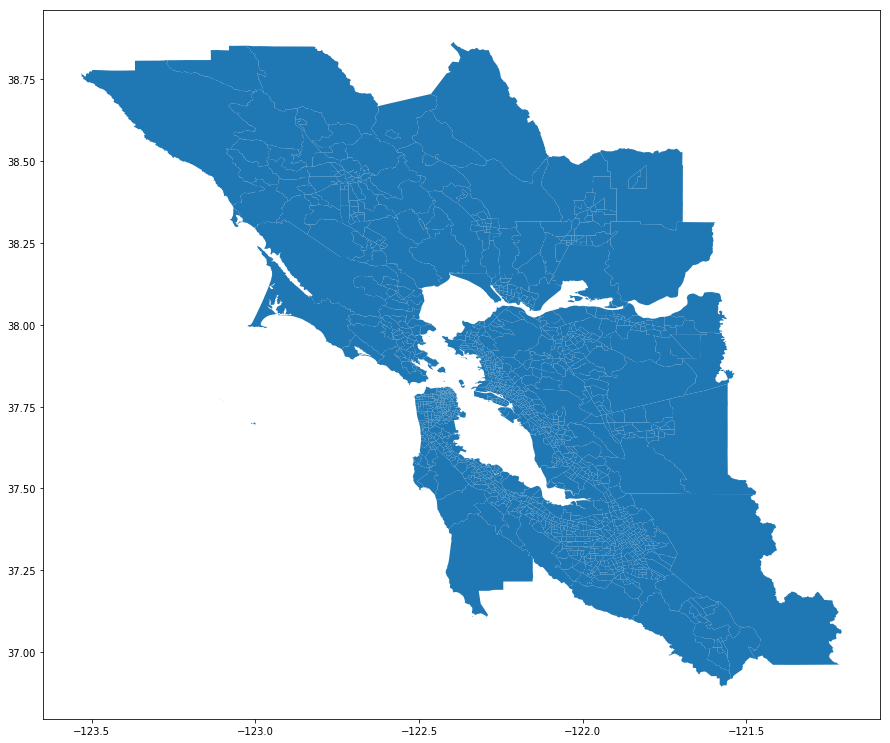

In [33]:
fig,ax = plt.subplots(figsize = (15, 15))
street_map.plot(ax = ax);

In [34]:
crs = {'init' : 'epsg:4326'}
df_1.head()

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,member_age,duration_min,duration_hours,start_time_month_name,start_time_weekday,distance_km
519697,240,424,37.782411,-122.392706,2017-06-28 09:54:41.187,1985.0,Female,21.0,37.789625,-122.400811,Montgomery St BART Station (Market St at 2nd St),2017-06-28 09:47:36.347,Subscriber,33,7.066667,0.117778,June,Wed,0.998476
519698,669,366,37.774814,-122.418954,2017-06-28 09:53:47.715,1981.0,Male,58.0,37.776619,-122.417385,Market St at 10th St,2017-06-28 09:47:41.664,Subscriber,37,6.100000,0.101667,June,Wed,0.204976
519699,117,188,37.782411,-122.392706,2017-06-28 09:52:55.338,1984.0,Male,25.0,37.787522,-122.397405,Howard St at 2nd St,2017-06-28 09:49:46.377,Subscriber,34,3.133333,0.052222,June,Wed,0.604730
519692,77,1201,37.798572,-122.400869,2017-06-28 10:11:00.359,1985.0,Male,81.0,37.775880,-122.393170,Berry St at 4th St,2017-06-28 09:50:59.175,Subscriber,33,20.016667,0.333611,June,Wed,1.600173
519696,316,431,37.780146,-122.403071,2017-06-28 10:03:51.090,1973.0,Male,66.0,37.778742,-122.392741,3rd St at Townsend St,2017-06-28 09:56:39.631,Subscriber,45,7.183333,0.119722,June,Wed,1.151688


In [35]:
geometry = [Point(xy) for xy in zip( df_1["start_station_longitude"], df_1["start_station_latitude"])]
geometry[:4]

In [36]:
geo_df = gpd.GeoDataFrame(df_1, crs = crs, geometry = geometry)
geo_df.head()

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,member_age,duration_min,duration_hours,start_time_month_name,start_time_weekday,distance_km,geometry
519697,240,424,37.782411,-122.392706,2017-06-28 09:54:41.187,1985.0,Female,21.0,37.789625,-122.400811,Montgomery St BART Station (Market St at 2nd St),2017-06-28 09:47:36.347,Subscriber,33,7.066667,0.117778,June,Wed,0.998476,POINT (-122.400811 37.7896254)
519698,669,366,37.774814,-122.418954,2017-06-28 09:53:47.715,1981.0,Male,58.0,37.776619,-122.417385,Market St at 10th St,2017-06-28 09:47:41.664,Subscriber,37,6.100000,0.101667,June,Wed,0.204976,POINT (-122.417385 37.776619)
519699,117,188,37.782411,-122.392706,2017-06-28 09:52:55.338,1984.0,Male,25.0,37.787522,-122.397405,Howard St at 2nd St,2017-06-28 09:49:46.377,Subscriber,34,3.133333,0.052222,June,Wed,0.604730,POINT (-122.3974049091339 37.78752178045625)
519692,77,1201,37.798572,-122.400869,2017-06-28 10:11:00.359,1985.0,Male,81.0,37.775880,-122.393170,Berry St at 4th St,2017-06-28 09:50:59.175,Subscriber,33,20.016667,0.333611,June,Wed,1.600173,POINT (-122.39317 37.77588)
519696,316,431,37.780146,-122.403071,2017-06-28 10:03:51.090,1973.0,Male,66.0,37.778742,-122.392741,3rd St at Townsend St,2017-06-28 09:56:39.631,Subscriber,45,7.183333,0.119722,June,Wed,1.151688,POINT (-122.3927408271084 37.77874161153677)


In [37]:
outliers_lat = geo_df[geo_df['start_station_latitude'] > 45]
outliers_long = geo_df[geo_df['start_station_longitude'] > -120]
geo_df = geo_df.drop(outliers_lat.index, axis=0)
geo_df = geo_df.drop(outliers_long.index, axis=0)

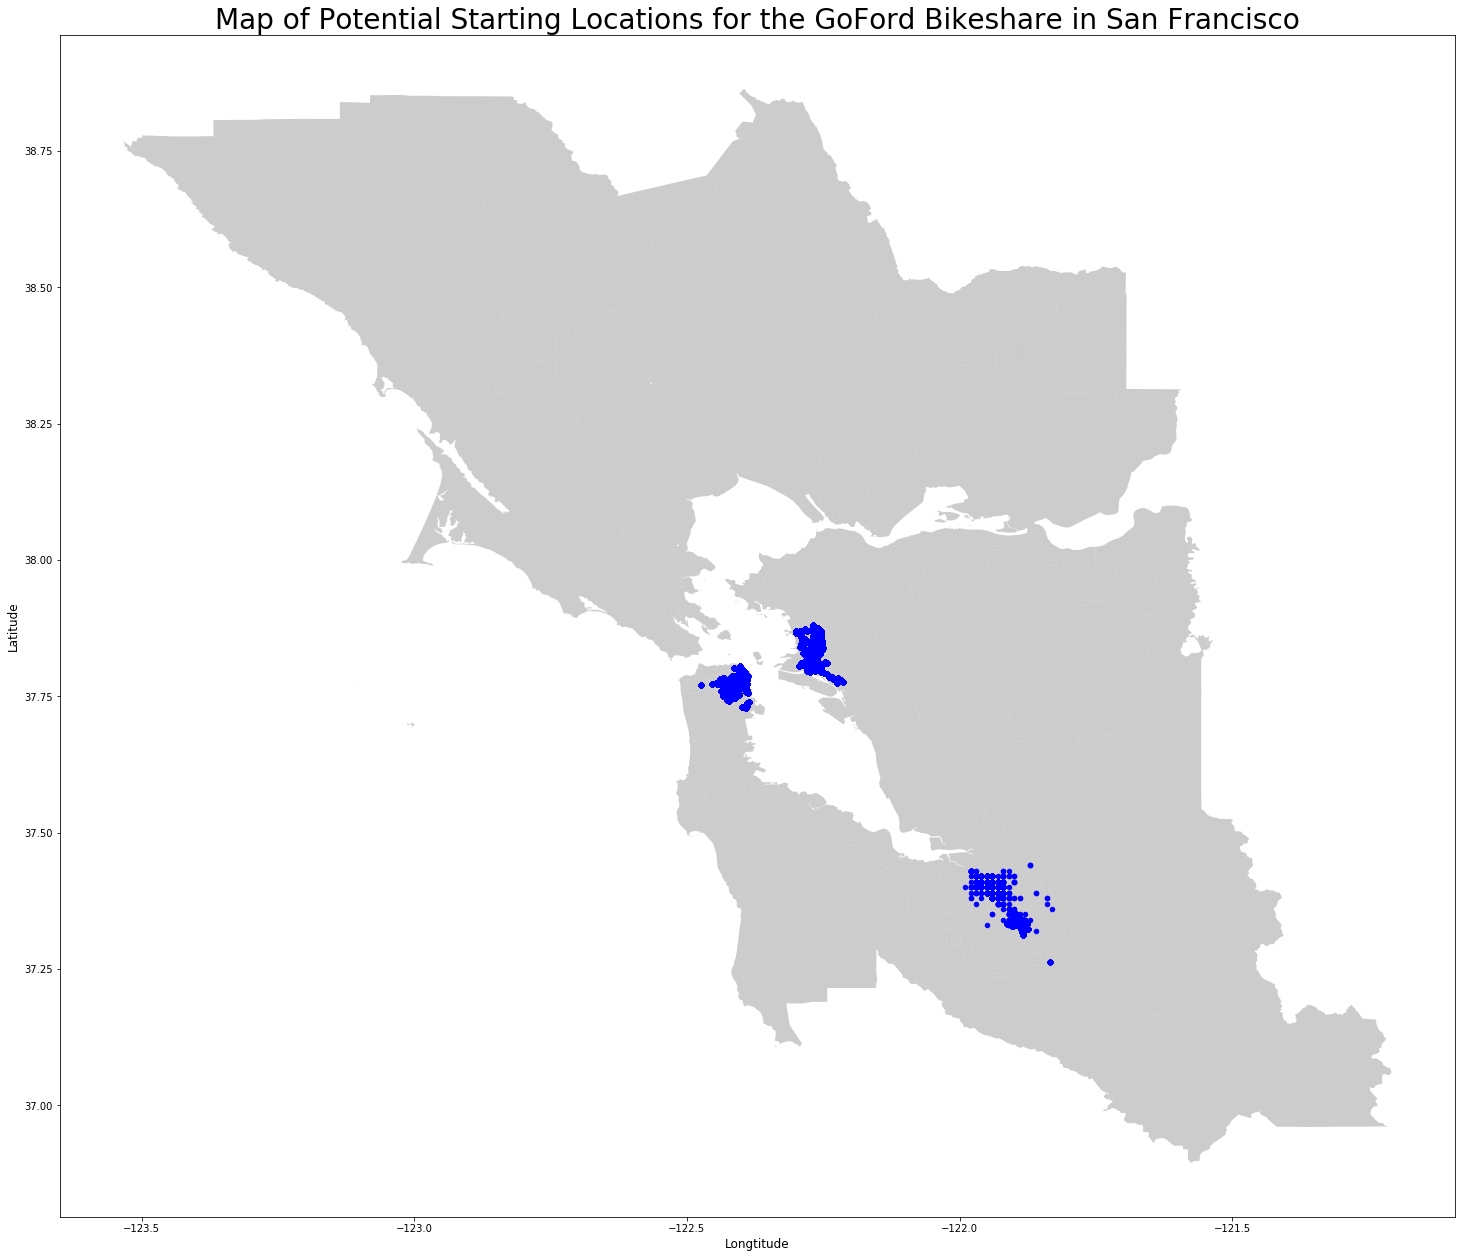

In [60]:
fig, ax = plt.subplots(figsize = (25, 25))
street_map.plot(ax=ax, alpha = 0.4, color = "grey")

geo_df.plot(ax = ax, markersize = 20, color = "blue", marker = "o")
plt.title("Map of Potential Starting Locations for the GoFord Bikeshare in San Francisco", fontsize=28, y=1.07)
plt.xlabel("Longtitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12);

Resource: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

## Univariate Exploration

First, I will check the distribution of subscription types, between customers and subscribers.

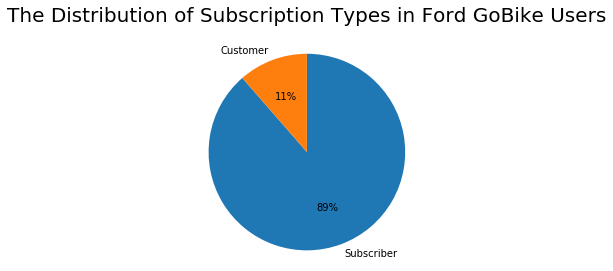

In [39]:
sorted_counts = df_1['user_type'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, autopct='%1.0f%%', startangle=90, counterclock = False)
plt.title("The Distribution of Subscription Types in Ford GoBike Users", fontsize=20, y=1.07)
plt.axis('square');

The majority of the users are subscribers, at 89%.

Next, I will create a boxplot of the ages for riders.

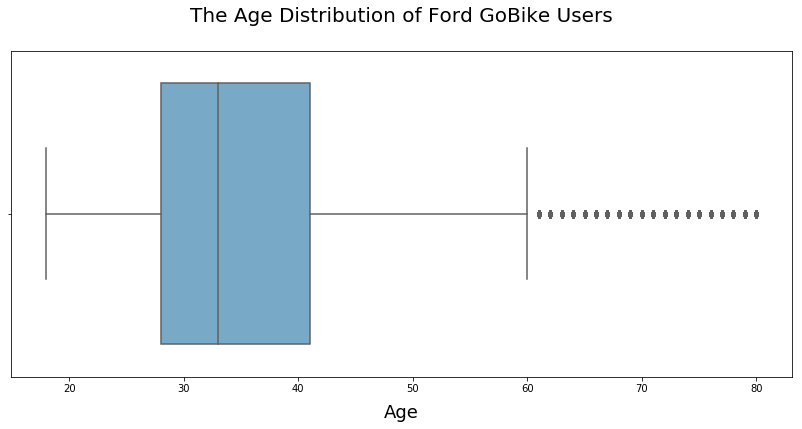

In [40]:
plt.figure(figsize=(14,6))
sb.boxplot(x='member_age', data=df_1, palette='Blues')
plt.title("The Age Distribution of Ford GoBike Users", fontsize=20, y=1.07)
plt.xlabel("Age", fontsize=18, labelpad=10);

In [41]:
df_1.member_age.mean()

35.44409922012951

In [42]:
df_1.member_age.describe()

count    2.054059e+06
mean     3.544410e+01
std      1.021092e+01
min      1.800000e+01
25%      2.800000e+01
50%      3.300000e+01
75%      4.100000e+01
max      8.000000e+01
Name: member_age, dtype: float64

The mean age is 35.4 years old, and after cleaning the data, the oldest age is 80 years old. 

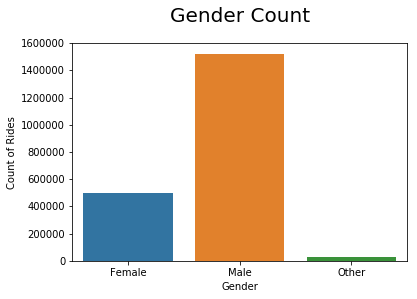

In [43]:
sb.countplot(data = df_1, x = 'member_gender')
plt.title("Gender Count", fontsize=20, y=1.07)
plt.xlabel('Gender')
plt.ylabel('Count of Rides');

Right away, we can see that the majority of users are male. I made a pie chart to see percentages of the genders.

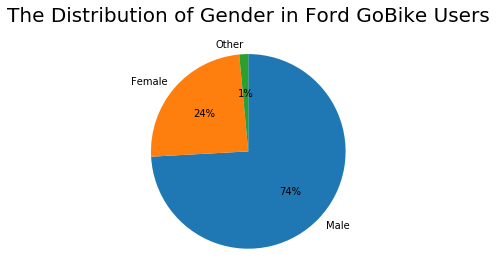

In [44]:
sorted_counts = df_1['member_gender'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, autopct='%1.0f%%', startangle=90, counterclock = False)
plt.title("The Distribution of Gender in Ford GoBike Users", fontsize=20, y=1.07)
plt.axis('square');

The pie chart shows us that 74% of the users are male, 24% are female, and 1% are other.

Now we can see how the time of year influences the number of rides.

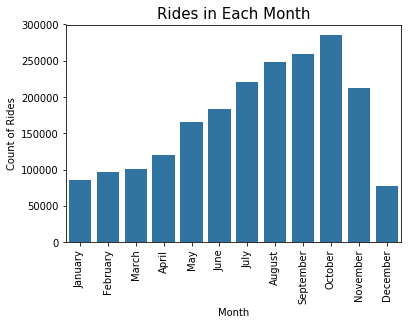

In [45]:
base_color = sb.color_palette()[0]

category_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                 'September', 'October', 'November', 'December']
sb.countplot(data = df_1, x = 'start_time_month_name', order = category_order, color = base_color)
plt.title('Rides in Each Month', fontsize = 15)
plt.xlabel('Month')
plt.ylabel('Count of Rides')
plt.xticks(rotation = 90);

The winter months have the fewest rides. The number of rides continues upwards throughout spring and summer, with the most popular being October. Then, the frequency of rides goes back down again.

Let's look at the number of rides per weekday.

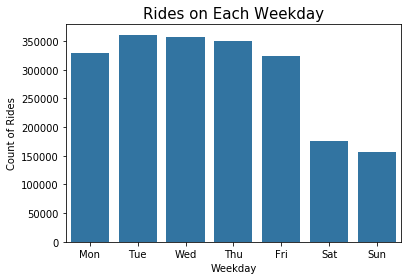

In [46]:
cat_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sb.countplot(data = df_1, x = 'start_time_weekday', order = cat_order, color = base_color)
plt.title('Rides on Each Weekday', fontsize = 15)
plt.xlabel('Weekday')
plt.ylabel('Count of Rides');

The rides are most frequent on Tuesday, Wednesday, and Thursday, followed by Monday and Friday. Saturday and Sunday are the least popular days.

We will now look at the distance traveled, in a histogram.

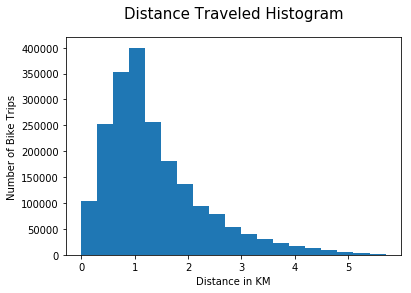

In [47]:
bin_edges = np.arange(0, 6, 0.3)
plt.hist(data = df_1, x = 'distance_km', bins = bin_edges)
plt.title("Distance Traveled Histogram", y = 1.06, fontsize = 15)
plt.xlabel('Distance in KM')
plt.ylabel('Number of Bike Trips');

The distance traveled histogram shows a right-skew (positive skew) to shorter rides. The mean length of ride is 1.38KM.

Next is a histogram for the duration of rides.

In [61]:
df_1.distance_km.mean()

1.3796241650078478

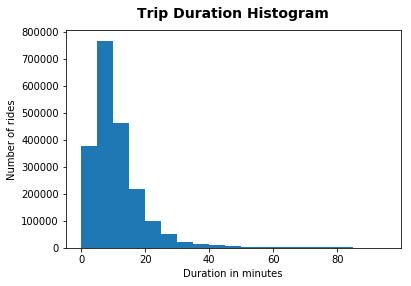

In [48]:
bin_edges = np.arange(0, 100, 5)

plt.hist(data = df_1, x = 'duration_min', bins = bin_edges)

plt.title("Trip Duration Histogram", y=1.03, fontsize=14, fontweight='semibold')
plt.xlabel('Duration in minutes')
plt.ylabel('Number of rides');


The histogram indicates that the majority of rides are less than 20 minutes long. The distribution is skewed to the right (positively skewed). The reason for this would be that single trips are \$2.00 for trips up to 30 min, otherwise you pay extra \$3.00 for additional 15 min. Only the monthly pass offers free of charge 45 min rides.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

This dataset required some cleaning. The cleaning performed earlier included removing some ages that were more than 80 years old (not very likely to be valid), and changing data types such as time and date. I also feature engineered the distance from the starting and ending locations, and also the longtitude and latitude to plot the starting locations on a map of the Bay Area.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Some of the birth years were obviously incorrect, as no rider would be 137 years old. I also removed the data for rows that didn't have gender or an age.

## Bivariate Exploration

In this section, I will explore how two factors of the dataset interact with each other. First, I will look at the daily usage for customers versus subscribers.

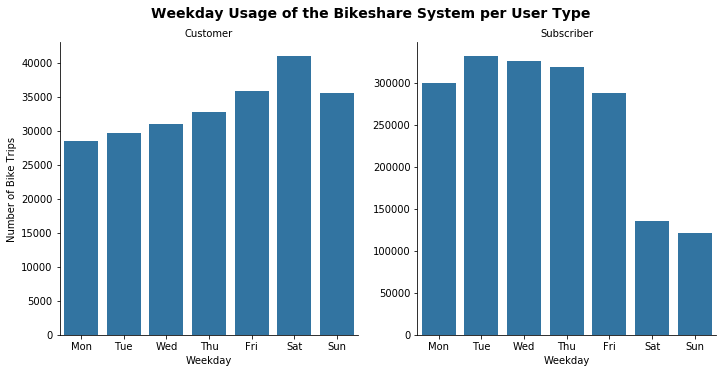

In [49]:
cat_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
g = sb.catplot(data=df_1, x='start_time_weekday', col="user_type", kind='count', sharey = False, order = cat_order, color = base_color)
g.set_axis_labels("Weekday", "Number of Bike Trips")
g.set_titles("{col_name}")
g.fig.suptitle('Weekday Usage of the Bikeshare System per User Type', y=1.03, fontsize=14, fontweight='semibold');


This analysis is quite illuminating as it shows that subscribers predominately use the ride service on Monday through Friday, while customers ride the most on the weekends. This is most likely due to subscribers using the service to commute to work, while customers use the bikes on an occasional basis for something unusual in their schedule.

Next, let's look at how customers and subscribers use the service on a monthly basis.

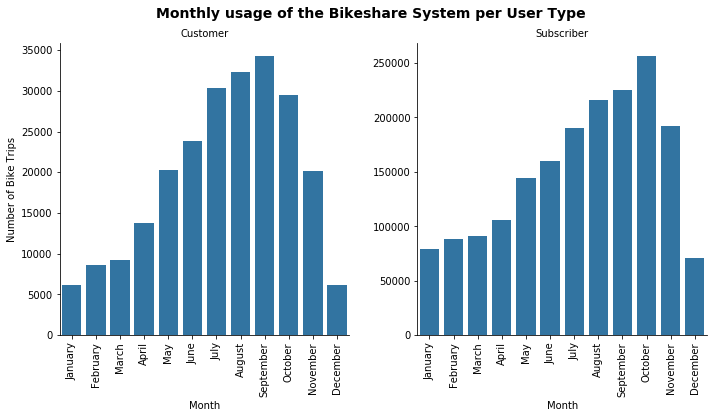

In [50]:
category_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                 'September', 'October', 'November', 'December']
g = sb.catplot(data=df_1, x='start_time_month_name', col="user_type", kind='count', order=category_order, sharex = True, sharey = False,
            color = base_color)
g.set_axis_labels("Month", "Number of Bike Trips")
g.set_titles("{col_name}")
g.fig.suptitle('Monthly usage of the Bikeshare System per User Type', y=1.03, fontsize=14, fontweight='semibold')
g.set_xticklabels(rotation=90);

Both customers and subscribers have a similar trend to their monthly usage, where it increases throughout the spring and fall until it drops in November, and for the remainder of the winter. However, the most popular usage month for customers is September, while the most popular month for subscribers is October.

The following analysis is for the length of trip for customers versus subscribers.

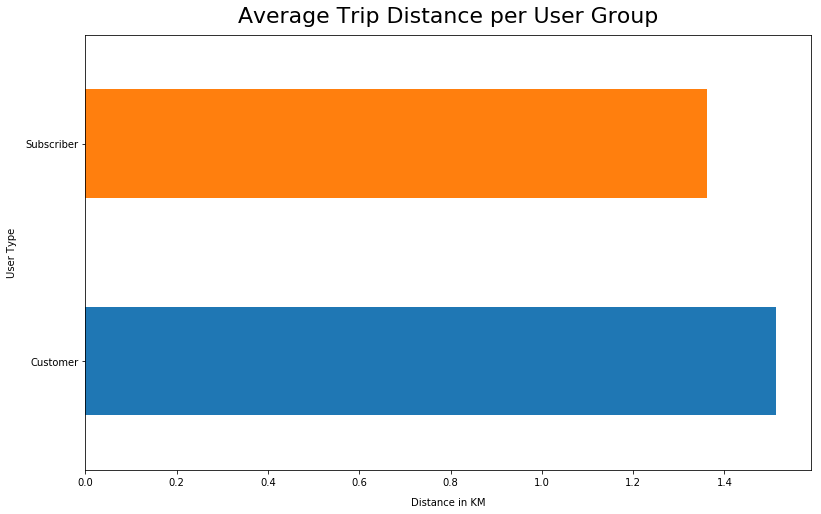

In [51]:
ax = df_1.groupby('user_type')['distance_km'].mean().plot(kind='barh', figsize=(13,8))
ax.set_title('Average Trip Distance per User Group', fontsize=22, y=1.015)
ax.set_ylabel('User Type', labelpad=8)
ax.set_xlabel('Distance in KM', labelpad=10);

In [52]:
df_1.groupby('user_type')['distance_km'].mean()

user_type
Customer      1.51332
Subscriber    1.36240
Name: distance_km, dtype: float64

The bar chart demonstrates that on average, customers take longer rides than subscribers. The mean for customers is 1.513KM, and the mean for subscribers is 1.362KM.


Moving away from customers versus subscribers, the next graph shows the age of a member along with the distance traveled between the start and end locations.

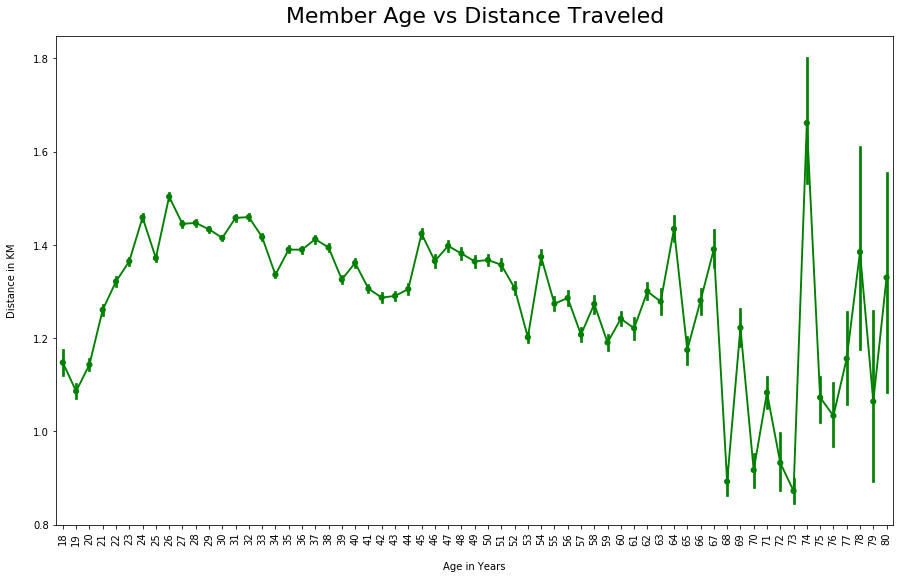

In [53]:
plt.figure(figsize=(15,9))
sb.pointplot(data = df_1, x='member_age', y='distance_km', scale=.7, color='green')
plt.title('Member Age vs Distance Traveled', fontsize=22, y=1.015)
plt.xlabel('Age in Years', labelpad=16)
plt.ylabel('Distance in KM', labelpad=16)
plt.xticks(rotation = 90);

This line graph shows that the oldest riders had the greatest fluctuation between the shorest and longest rides.
Of course, it is possible for the rider to not take a direct trip from the starting to ending locations, and to deviate from a straight course. However, it is worthwhile to understand how far away the starting and ending locations are from each other.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

It was interesting to observe the different usage behaviors between subscribers and customers. Customers show trends towards being more casual in their usage, as they ride more on the weekends, and subscribers appear to use the service on a Monday-Friday basis. It seems likely that subscribers are using the service to commute to work. However, it was surprising to see that customers, on average, take longer rides than subscribers.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

The relationship between the member's age and length of ride is investigated with a line graph. The greatest fluctuation between the shorest and longest rides is with the older riders.

## Multivariate Exploration

First, I will analyze the distributions between customer and subscriber, based on gender and weekday usage.

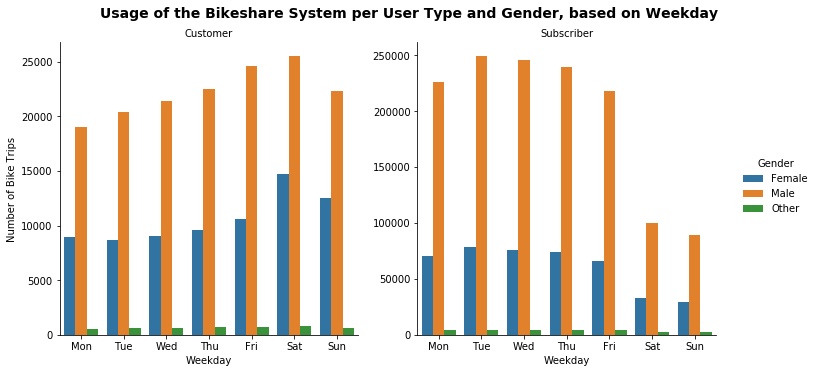

In [54]:
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
g = sb.catplot(data=df_1, x='start_time_weekday', col="user_type", hue='member_gender', kind='count', sharey = False,
                order = weekday)
g.set_axis_labels("Weekday", "Number of Bike Trips")
g._legend.set_title('Gender')
g.set_titles("{col_name}")
g.fig.suptitle('Usage of the Bikeshare System per User Type and Gender, based on Weekday', y=1.03, fontsize=14, fontweight='semibold');


While there is less female and other gender usage than male, the trend between customers and subscribers of each gender is similar. Customers of all genders use the service more often on the weekends, while subscribers use the system during the week, predominately.

Now we will look at the same categories, but per month instead.

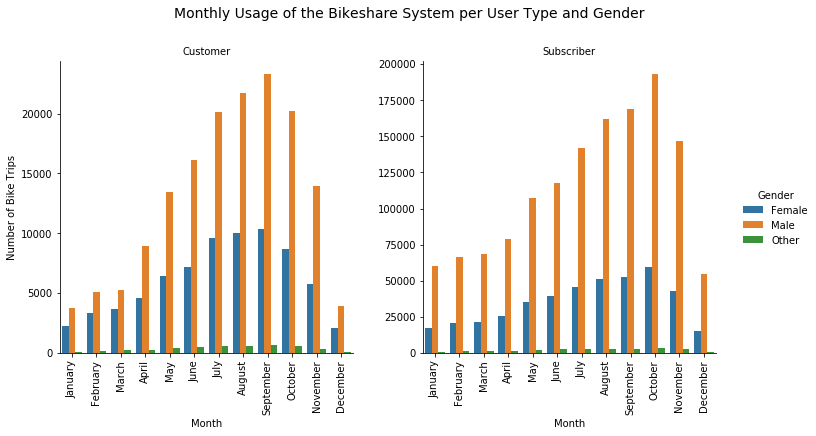

In [55]:
category_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                 'September', 'October', 'November', 'December']
g = sb.catplot(data=df_1, x='start_time_month_name', col="user_type", hue="member_gender", kind='count', sharey = False, order = category_order)
g.set_axis_labels("Month", "Number of Bike Trips")
g._legend.set_title('Gender')
g.set_titles("{col_name}")
g.fig.suptitle('Monthly Usage of the Bikeshare System per User Type and Gender', y=1.08, fontsize=14)
g.set_xticklabels(rotation=90);

Again, we find that each gender follows a similar pattern to the other genders. The winter months are not as popular for customers or subscribers, and usage increases as the summer and fall occur.

This data would look interesting as a heatmap.

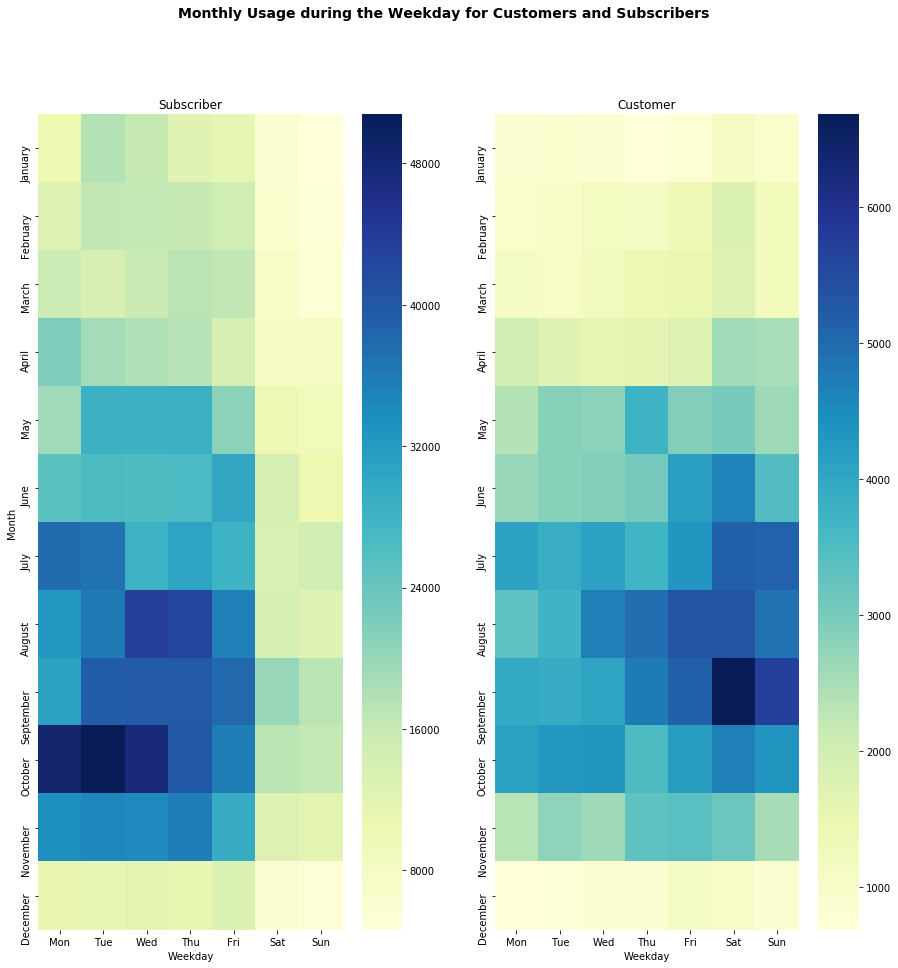

In [56]:
# Setting the weekday order
df_1['start_time_weekday'] = pd.Categorical(df_1['start_time_weekday'], 
                                                categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], 
                                                ordered=True)
df_1['start_time_month_name'] = pd.Categorical(df_1['start_time_month_name'], 
                                                categories=['January','February','March', 'April', 'May', 'June', 'July', 'August', 
                 'September', 'October', 'November', 'December'], 
                                                ordered=True)
plt.figure(figsize=(15,15))
plt.suptitle('Monthly Usage during the Weekday for Customers and Subscribers', fontsize=14, fontweight='semibold')

# heatmap for subscribers
plt.subplot(1, 2, 1)
df_subscriber = df_1.query('user_type == "Subscriber"').groupby(["start_time_month_name", "start_time_weekday"])["bike_id"].size().reset_index()
df_subscriber = df_subscriber.pivot("start_time_month_name", "start_time_weekday", "bike_id")
sb.heatmap(df_subscriber, cmap="YlGnBu")

plt.title("Subscriber", y=1.015)
plt.xlabel('Weekday')
plt.ylabel('Month');
# heatmap for customers
plt.subplot(1, 2, 2)
df_customer = df_1.query('user_type == "Customer"').groupby(["start_time_month_name", "start_time_weekday"])["bike_id"].size().reset_index()
df_customer = df_customer.pivot("start_time_month_name", "start_time_weekday", "bike_id")
sb.heatmap(df_customer, cmap="YlGnBu")


plt.title("Customer", y=1.015)
plt.xlabel('Weekday')
plt.ylabel('');



It is easy to visualize the usage in this heatmap, as the darker colors indicate the most rides occuring. The summer and fall are the most popular for both users, and customers prefer the weekend, compared to subcribers.

The following graph is a line graph of the distances traveled by each age, separated by gender.

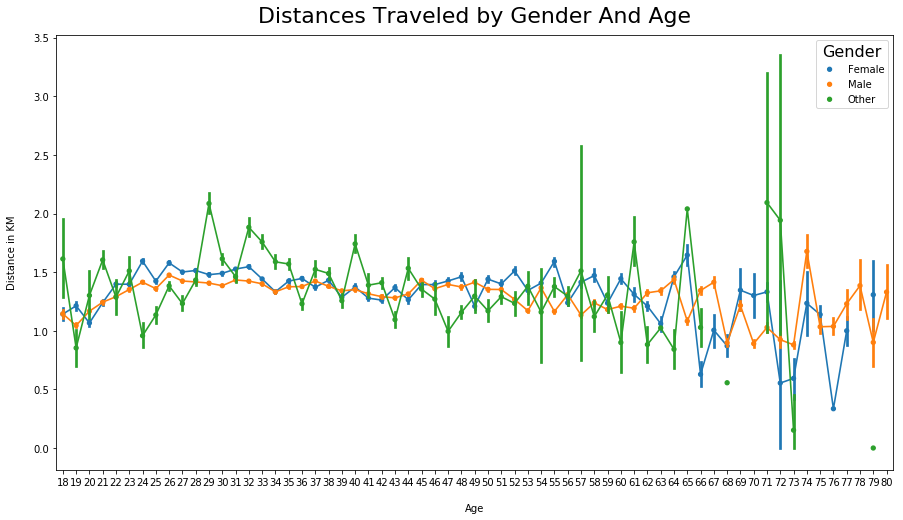

In [57]:
plt.figure(figsize=(15,8))
ax = sb.pointplot(x='member_age', y='distance_km', hue='member_gender', scale=.6, data=df_1)
plt.title('Distances Traveled by Gender And Age', fontsize=22, y=1.015)
plt.xlabel('Age', labelpad=16)
plt.ylabel('Distance in KM', labelpad=16)
leg = ax.legend()
leg.set_title('Gender',prop={'size':16})
ax = plt.gca();


Interestingly, the other gender has the greatest fluctuation, especially in the 50 years and older demographic.


Resource: https://matplotlib.org/3.1.0/gallery/

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

The multivariate charts reinforced the earlier relationships that were observed. The customers prefer to use the Bikeshare on weekends, and the subscribers use the service on Monday-Friday, the most. This was not influenced by gender. The same can be said about usage over the months, as the summer and fall are the most popular usage times, regardless of any other factors.

### Were there any interesting or surprising interactions between features?

It was surprising to note that the "other gender" category had the most outliers in the data, as well as ages over 50 years. 